In [1]:
!pip install --upgrade jax==0.5.1 jaxlib==0.5.1
!pip install jaxkan diffrax

In [2]:
from jaxkan.KAN import KAN
import jax
import jaxlib
import jax.numpy as jnp
import numpy as np
from flax import nnx
import optax
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, PIDController
import matplotlib.pyplot as plt
import time

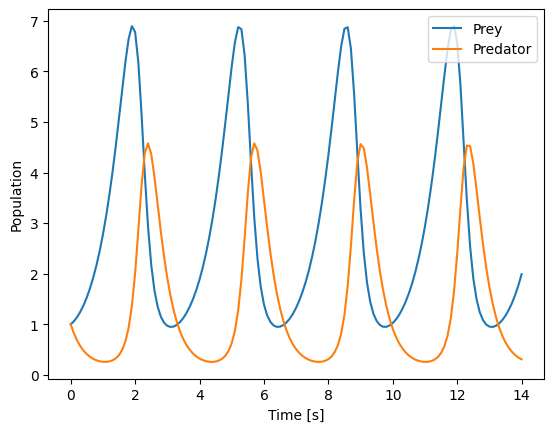

In [3]:
# Ground Truth:

def vector_field(t, y, args):

    prey, predator = y
    α, β, γ, δ = args
    d_prey = α * prey - β * prey * predator
    d_predator = γ * prey * predator - δ * predator
    d_y = d_prey, d_predator

    return d_y

term = ODETerm(vector_field)
solver = Tsit5()
t0 = 0
t1 = 14
dt0 = 0.1
y0 = (1,1)
args = (1.5, 1, 1, 3)
stepsize_controller = PIDController(rtol = 1e-4, atol = 1e-6)
saveat = SaveAt(ts = jnp.linspace(t0, t1, 141))

sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args = args, stepsize_controller = stepsize_controller, saveat = saveat)

plt.plot(sol.ts, sol.ys[0], label = "Prey")
plt.plot(sol.ts, sol.ys[1], label = "Predator")
plt.xlabel("Time [s]")
plt.ylabel("Population")
plt.legend()
plt.show()

In [4]:
# Dataset:

t = sol.ts
solutions = jnp.stack((sol.ys[0], sol.ys[1]), axis = 1)

t_train = t[:36]
solutions_train = solutions[:36, :]

t_test = t[36:]
solutions_test = solutions[36:, :]

window_size = 9
step_size = 3

n_train_windows = (solutions_train.shape[0] - window_size) // step_size + 1
t_train = jnp.stack([t_train[i:i+window_size] for i in range(0, n_train_windows * step_size, step_size)])
solutions_train = jnp.stack([solutions_train[i:i+window_size] for i in range(0, n_train_windows * step_size, step_size)])

n_test_windows = (solutions_test.shape[0] - window_size) // step_size + 1
t_test = jnp.stack([t_test[i:i+window_size] for i in range(0, n_test_windows * step_size, step_size)])
solutions_test = jnp.stack([solutions_test[i:i+window_size] for i in range(0, n_test_windows * step_size, step_size)])

n_windows = (solutions.shape[0] - window_size) // step_size + 1
t = jnp.stack([t[i:i+window_size] for i in range(0, n_windows * step_size, step_size)])
solutions = jnp.stack([solutions[i:i+window_size] for i in range(0, n_windows * step_size, step_size)])

train_indices = np.random.permutation(n_train_windows)
test_indices = np.random.permutation(n_test_windows)
indices = np.random.permutation(n_windows)

t_train = t_train[train_indices]
solutions_train = solutions_train[train_indices]

t_test = t_test[test_indices]
solutions_test = solutions_test[test_indices]

t = t[indices]
solutions = solutions[indices]

print(f"Train instances: {solutions_train.shape}")
print(f"Test instances: {solutions_test.shape}")

Train instances: (10, 9, 2)
Test instances: (33, 9, 2)


In [5]:
# Models definitions:

class dF(nnx.Module):

    def __init__(self, dy_dt):
        self.dy_dt = dy_dt
    def __call__(self, t, y, args):
        return self.dy_dt(y)

class MLP(nnx.Module):

    def __init__(self, layer_dims, rngs: nnx.Rngs):

        self.layers = [
            nnx.Linear(layer_dims[i], layer_dims[i + 1], rngs = rngs)
            for i in range(len(layer_dims) - 1)]

    def __call__(self, t,y,args):

        for layer in self.layers[:-1]:
            y = layer(y)
            y = jnp.tanh(y)

        y = self.layers[-1](y)

        return y

class NODE(nnx.Module):

    def __init__(self,dF):
        self.dF = dF

    def __call__(self, ts, y0):
        solution = diffeqsolve(
            ODETerm(self.dF),
            Tsit5(),
            t0 = ts[0],
            t1 = ts[-1],
            dt0 = ts[1] - ts[0],
            y0 = y0,
            stepsize_controller = PIDController(rtol = 1e-4, atol = 1e-6),
            saveat = SaveAt(ts = ts),
        )
        return solution.ys[:,0,:]

In [6]:
# Initial conditions:

y0_train = solutions_train[:, None, 0, :]
y0_test = solutions_test[:, None, 0, :]
y0 = solutions[:, None, 0, :]

# Optimizer:

opt_type = optax.adam(learning_rate = 0.001)

# Loss function:

def loss_fn(model, t, y0, solutions_true):
    solutions_pred = jax.vmap(model, in_axes=(0, 0))(t, y0)
    return jnp.mean((solutions_pred - solutions_true) ** 2)

In [7]:
# L2 relative error:

def l2_relative_error(y_pred, y_true):
    numerator = jnp.linalg.norm(y_pred - y_true)
    denominator = jnp.linalg.norm(y_true)
    return numerator / denominator

In [8]:
# Training step:

@nnx.jit
def train_step(model, optimizer, t_train, y0_train, solutions_train):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, y0_train, solutions_train)
    optimizer.update(grads)

    return train_loss

# Test step:

@nnx.jit
def test_step(model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, y0_train, solutions_train)
    optimizer.update(grads)
    test_loss = loss_fn(model, t_test, y0_test, solutions_test)
    l2_error = l2_relative_error(jax.vmap(model, in_axes=(0, 0))(t, y0), solutions)

    return train_loss, test_loss, l2_error

In [9]:
# Training function:

def train(model, optimizer, t_train, y0_train, solutions_train, num_epochs):

    train_losses = jnp.zeros(num_epochs)
    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss = train_step(model, optimizer, t_train, y0_train, solutions_train)
        train_losses = train_losses.at[epoch].set(train_loss)

    print(f"Training time: {(time.time() - start_time)/num_epochs:.3f} seconds")

    return train_losses

# Test function:

def test(model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions, num_epochs):

    train_losses = jnp.zeros(num_epochs)
    test_losses = jnp.zeros(num_epochs)
    l2_errors = jnp.zeros(num_epochs)

    for epoch in range(num_epochs):
        train_loss, test_loss, l2_error = test_step(model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions)
        train_losses = train_losses.at[epoch].set(train_loss)
        test_losses = test_losses.at[epoch].set(test_loss)
        l2_errors = l2_errors.at[epoch].set(l2_error)

    return train_losses, test_losses, l2_errors

In [10]:
num_epochs = 10000

In [11]:
# KAN-ODE-spline training:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 5}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_spline = train(KANODE_model, optimizer, t_train, y0_train, solutions_train, num_epochs)

Training time: 0.028 seconds


In [12]:
# KAN-ODE-spline test:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 5}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_spline, test_losses_spline, l2_errors_spline = test(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions, num_epochs)

In [13]:
# KAN-ODE-chebyshev training:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'chebyshev',
            required_parameters = {'D': 8, 'flavor': 'exact', 'external_weights': True, 'residual':nnx.silu}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_chebyshev = train(KANODE_model, optimizer, t_train, y0_train, solutions_train, num_epochs)

Training time: 0.022 seconds


In [14]:
# KAN-ODE-chebyshev test:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'chebyshev',
            required_parameters = {'D': 8, 'flavor': 'exact', 'external_weights': True, 'residual':nnx.silu}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_chebyshev, test_losses_chebyshev, l2_errors_chebyshev = test(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions, num_epochs)

In [17]:
# KAN-ODE-legendre training:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'legendre',
            required_parameters = {'D': 8, 'flavor' : 'exact', 'external_weights' : True, 'residual' : nnx.silu},
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_legendre = train(KANODE_model, optimizer, t_train, y0_train, solutions_train, num_epochs)

Training time: 0.018 seconds


In [18]:
# KAN-ODE-legendre test:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'legendre',
            required_parameters = {'D': 8, 'flavor' : 'exact', 'external_weights' : True, 'residual' : nnx.silu},
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_legendre, test_losses_legendre, l2_errors_legendre = test(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions, num_epochs)

In [19]:
# KAN-ODE-rbf training:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'rbf',
            required_parameters = {'D': 8, 'external_weights' : True, 'residual' : nnx.silu, 'kernel' : {'type': 'gaussian'}}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_rbf = train(KANODE_model, optimizer, t_train, y0_train, solutions_train, num_epochs)

Training time: 0.014 seconds


In [20]:
# KAN-ODE-rbf test:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'rbf',
            required_parameters = {'D': 8, 'external_weights' : True, 'residual' : nnx.silu, 'kernel' : {'type': 'gaussian'}}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_rbf, test_losses_rbf, l2_errors_rbf = test(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions, num_epochs)

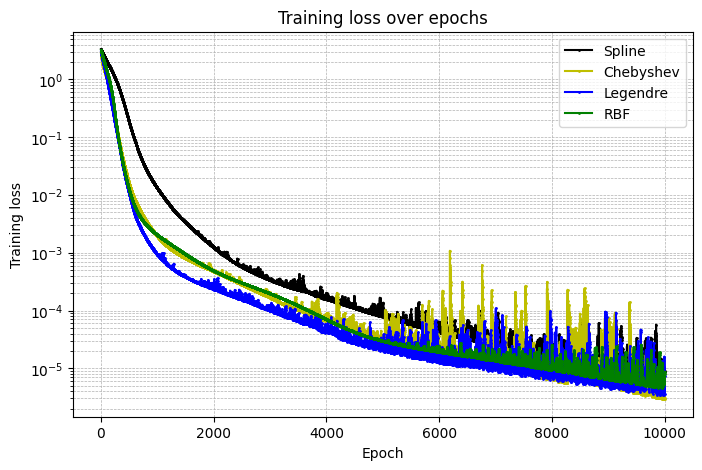

In [23]:
# Training loss:

plt.figure(figsize = (8, 5))

plt.plot(np.array(train_losses_spline), label = 'Spline', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(train_losses_chebyshev), label = 'Chebyshev', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(train_losses_legendre), label = 'Legendre', marker = 'o', color = 'b', markersize = 1)
plt.plot(np.array(train_losses_rbf), label = 'RBF', marker = 'o', color = 'g', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [26]:
# Final training losses:

print(f"Final training loss for the 'spline' KAN-ODE : {train_losses_spline[-1]:.7f}")
print(f"Final training loss for the 'chebyshev' KAN-ODE:  {train_losses_chebyshev[-1]:.7f}")
print(f"Final training loss for the 'legendre' KAN-ODE:  {train_losses_legendre[-1]:.7f}")
print(f"Final training loss for the 'rbf' KAN-ODE:  {train_losses_rbf[-1]:.7f}")

Final training loss for the 'spline' KAN-ODE : 0.0000092
Final training loss for the 'chebyshev' KAN-ODE:  0.0000029
Final training loss for the 'legendre' KAN-ODE:  0.0000075
Final training loss for the 'rbf' KAN-ODE:  0.0000087


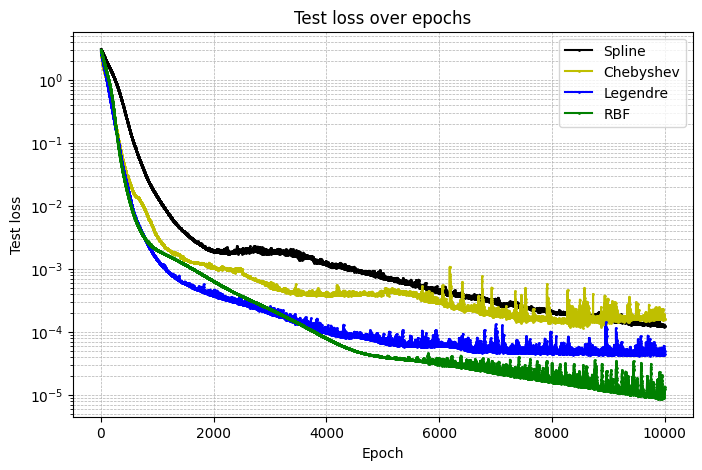

In [27]:
# Test loss:

plt.figure(figsize = (8, 5))

plt.plot(np.array(test_losses_spline), label = 'Spline', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(test_losses_chebyshev), label = 'Chebyshev', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(test_losses_legendre), label = 'Legendre', marker = 'o', color = 'b', markersize = 1)
plt.plot(np.array(test_losses_rbf), label = 'RBF', marker = 'o', color = 'g', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [29]:
# Final test losses:

print(f"Final test loss for the 'spline' KAN-ODE : {test_losses_spline[-1]:.6f}")
print(f"Final test loss for the 'chebyshev' KAN-ODE:  {test_losses_chebyshev[-1]:.6f}")
print(f"Final test loss for the 'legendre' KAN-ODE:  {test_losses_legendre[-1]:.6f}")
print(f"Final test loss for the 'rbf' KAN-ODE:  {test_losses_rbf[-1]:.6f}")

Final test loss for the 'spline' KAN-ODE : 0.000126
Final test loss for the 'chebyshev' KAN-ODE:  0.000162
Final test loss for the 'legendre' KAN-ODE:  0.000044
Final test loss for the 'rbf' KAN-ODE:  0.000014


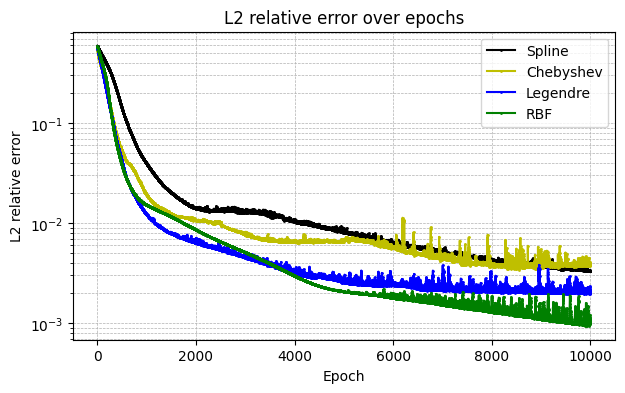

In [30]:
# L2 relative error:

plt.figure(figsize = (7, 4))

plt.plot(np.array(l2_errors_spline), label = 'Spline', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(l2_errors_chebyshev), label = 'Chebyshev', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(l2_errors_legendre), label = 'Legendre', marker = 'o', color = 'b', markersize = 1)
plt.plot(np.array(l2_errors_rbf), label = 'RBF', marker = 'o', color = 'g', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('L2 relative error')
plt.title('L2 relative error over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [32]:
# Final L2 relative errors:

print(f"Final L2 relative error for the 'spline' KAN-ODE : {l2_errors_spline[-1]:.4f}")
print(f"Final L2 relative error for the 'chebyshev' KAN-ODE:  {l2_errors_chebyshev[-1]:.4f}")
print(f"Final L2 relative error for the 'legendre' KAN-ODE:  {l2_errors_legendre[-1]:.4f}")
print(f"Final L2 relative error for the 'rbf' KAN-ODE:  {l2_errors_rbf[-1]:.4f}")

Final L2 relative error for the 'spline' KAN-ODE : 0.0033
Final L2 relative error for the 'chebyshev' KAN-ODE:  0.0038
Final L2 relative error for the 'legendre' KAN-ODE:  0.0020
Final L2 relative error for the 'rbf' KAN-ODE:  0.0012


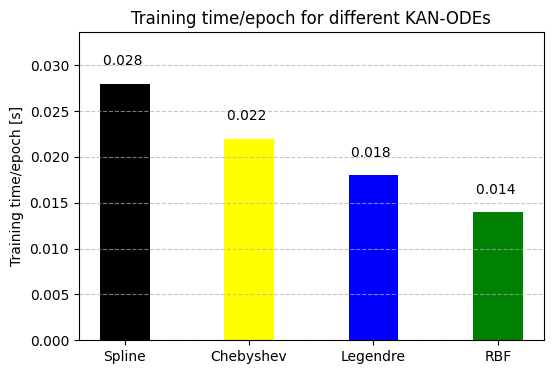

In [34]:
# Training time/epoch:

models = ["Spline", "Chebyshev", "Legendre", 'RBF']
training_times = [0.028, 0.022, 0.018, 0.014]

plt.figure(figsize=(6, 4))
plt.bar(models, training_times, color=['black', 'yellow', 'blue', 'green'], width = 0.4)


plt.ylabel("Training time/epoch [s]")
plt.title("Training time/epoch for different KAN-ODEs")
plt.ylim(0, max(training_times) * 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, time in enumerate(training_times):
    plt.text(i, time + 0.002, f"{time:.3f} ", ha="center", fontsize=10)

plt.show()

In [35]:
# Experiment (training times ~ 280 s):

In [36]:
# KAN-ODE-spline test:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 5}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_spline, test_losses_spline, l2_errors_spline = test(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions, num_epochs)

In [37]:
# KAN-ODE-chebyshev test:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'chebyshev',
            required_parameters = {'D': 8, 'flavor': 'exact', 'external_weights': True, 'residual':nnx.silu}
           )

num_epochs = 12740

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_chebyshev, test_losses_chebyshev, l2_errors_chebyshev = test(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions, num_epochs)

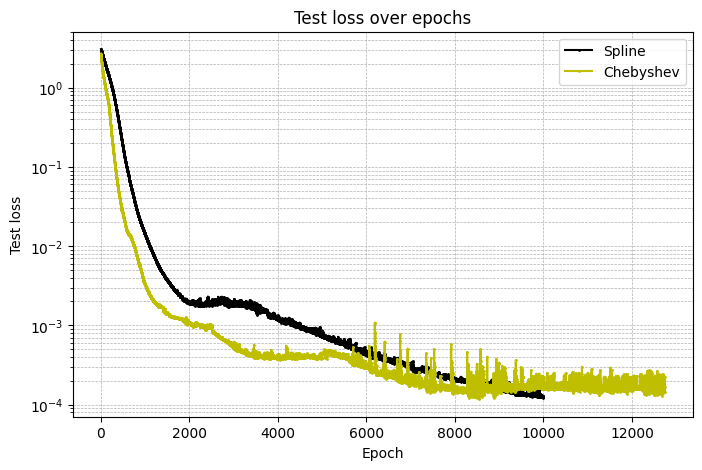

In [38]:
# Test loss:

plt.figure(figsize = (8, 5))

plt.plot(np.array(test_losses_spline), label = 'Spline', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(test_losses_chebyshev), label = 'Chebyshev', marker = 'o', color = 'y', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [43]:
# Final test losses:

print(f"Final test loss for the 'spline' KAN-ODE : {test_losses_spline[-1]:.6f}")
print(f"Final test loss for the 'chebyshev' KAN-ODE:  {test_losses_chebyshev[-1]:.6f}")

Final test loss for the 'spline' KAN-ODE : 0.000126
Final test loss for the 'chebyshev' KAN-ODE:  0.000143


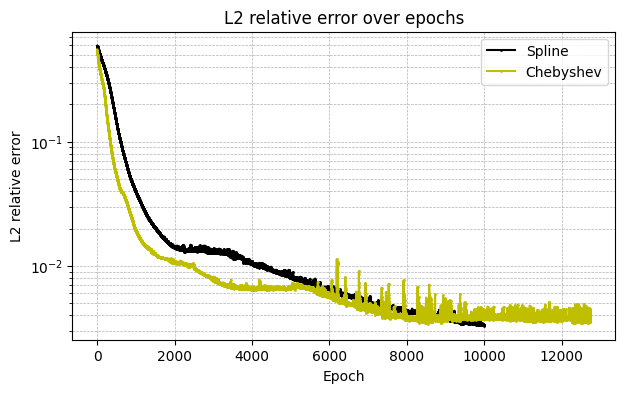

In [44]:
# L2 relative error:

plt.figure(figsize = (7, 4))

plt.plot(np.array(l2_errors_spline), label = 'Spline', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(l2_errors_chebyshev), label = 'Chebyshev', marker = 'o', color = 'y', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('L2 relative error')
plt.title('L2 relative error over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [46]:
# Final L2 relative errors:

print(f"Final L2 relative error for the 'spline' KAN-ODE : {l2_errors_spline[-1]:.5f}")
print(f"Final L2 relative error for the 'chebyshev' KAN-ODE:  {l2_errors_chebyshev[-1]:.5f}")

Final L2 relative error for the 'spline' KAN-ODE : 0.00334
Final L2 relative error for the 'chebyshev' KAN-ODE:  0.00356
